# Particle Filtering

__Overview__: This lab is meant as an introduction to particle filtering.

__Goals__: Students should:

1. Be able to implement the particle filtering algorithm to reconstruct the filtering distributions.
2. Use the particle filtering algorithm to predict future latent states and observations.

In [1]:
from typing import Tuple

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Parameters for our distribution p(observation|latent)
GAUSS_WEIGHTS = [0.3, 0.3, 0.4]
GAUSS_MEANS = [np.zeros(2), np.array([2.0,0.6]), np.array([-1.4,0.2])]
GAUSS_COVS = [np.eye(2) * 3.0, np.eye(2)*2.0, np.eye(2) * 0.1]

def observation_probability(latent: np.ndarray, observation: np.ndarray) -> float:
    """Given an observation and corresponding latent state, evaluate the likelihood.

    Args:
        latent: Latent state at current time step.
        observation: Observation at current time step.

    Returns:
        Likelihood p(observation|latent).
    """
    # Let's keep things somewhat 'simple' by making our distribution a sum of Gaussians
    likelihood = 0
    for weight, mean, cov in zip(GAUSS_WEIGHTS, GAUSS_MEANS, GAUSS_COVS):
        evaluation_mean = latent + mean
        likelihood += (
            weight * stats.multivariate_normal(mean=evaluation_mean, cov=cov).pdf(observation)
        )
    return likelihood

def observation_sample(latent: np.ndarray) -> np.ndarray:
    """Given the latent state, sample a observation.

    Args:
        latent: Latent state at current time step.

    Returns:
        Sampled observation.
    """
    # Let's keep things somewhat 'simple' by making our distribution a sum of Gaussians
    index = np.random.choice(np.arange(3), p=GAUSS_WEIGHTS)
    evaluation_mean = latent + GAUSS_MEANS[index]
    cov = GAUSS_COVS[index]
    return stats.multivariate_normal(mean=evaluation_mean, cov=cov).rvs()

def latent_sample(latent: np.ndarray) -> np.ndarray:
    """Given the latent state, sample the next latent state.

    Args:
        latent: Latent state at current time step.

    Returns:
        Sampled latent state.
    """
    # Let's keep things somewhat 'simple' by making our distribution a sum of Gaussians
    sample = np.zeros(len(latent))
    sample[0] = np.sin(latent[1]) + np.random.randn() * 0.05
    sample[1] = np.cos(latent[0]) + np.random.randn() * 0.05
    sample += 1.0 * latent
    return sample
    

## Part 1: Where's the rat again?

Your friend in the biology department is back. Apparently they wanted to build on last week and they kept playing music to their rat. They didn't get much of a response until they started playing _your favorite song_. That's right, _your favorite song_. What are the odds? Anyways, the rat started moving wildly and the sensors once again struggled to track the rat.

Thankfully, since last week, your friend has been putting a lot work into building a physically motivated model for the rat's motion and the observations. They come to you with the data and three different distributions:

$$
z_t = g(z_{t-1})
$$
$$
x_t = f(z_{t-1})
$$
$$
p(x_t | z_t),
$$
where $g$ and $f$ are sampling functions for the latent states / observations, and $p(x_t | z_t)$ is the observation probability density function. Your friend was so on top of it this week, that they already loaded them into your notebook as _latent_sample_, _observation_sample_, and _observation_probability_.

They hand you the data of the observed motion of the rat, and they ask you to reconstruct its latent state once again. "It's going to be Gaussians isn't it," they say. Oh boy, are they in for a treat.

In the cell below, we generate the data for you. You will then have to implement the particle filtering class. This will require:

* Writing a function to compute the weights given latent space samples.
* Writing a function to compute the particle filtering samples for all time steps.
* Writing a function to predict future latent states and observations.

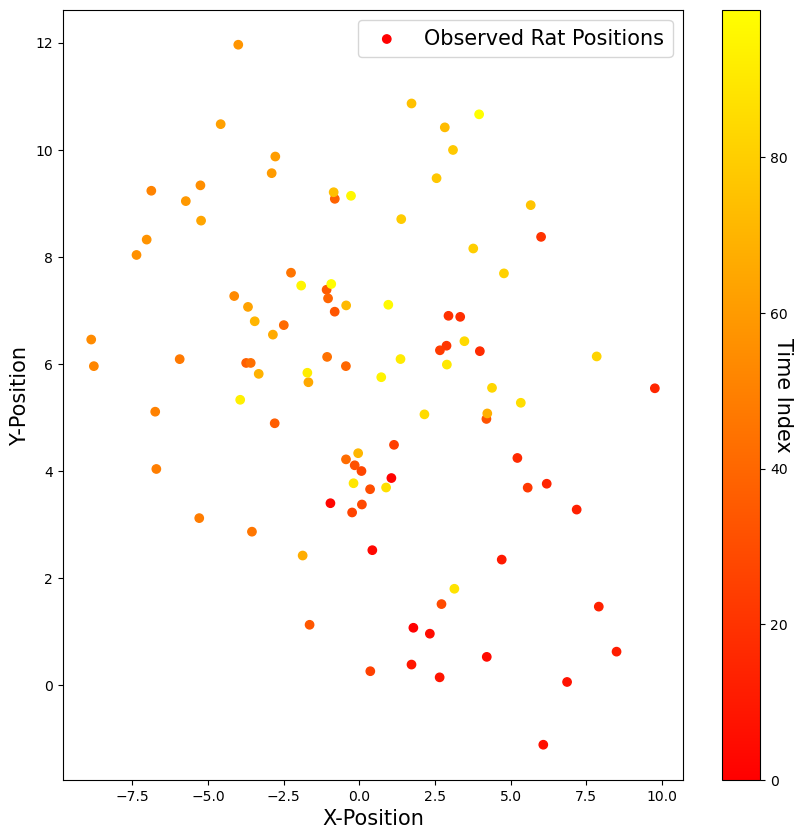

In [3]:
# Let's generate a true set of latent states and observations for our analysis.
latent_states = np.zeros((101,2))
observation_states = np.zeros((len(latent_states)-1,2))
t_observed = np.arange(len(observation_states))
np.random.seed(3)
for i in range(1, len(latent_states)):
    latent_states[i] = latent_sample(latent_states[i-1])
    observation_states[i-1] = observation_sample(latent_states[i])


# Let's visualize our data.
fig, ax = plt.subplots(1, 1, figsize=(10,10), dpi=100)
fontsize = 15
plt.scatter(observation_states[:,0], observation_states[:,1], c=t_observed, 
            cmap='autumn', label='Observed Rat Positions')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Time Index', fontsize=fontsize, rotation=270)
plt.xlabel('X-Position', fontsize=fontsize)
plt.ylabel('Y-Position', fontsize=fontsize)
plt.legend(fontsize=fontsize)

plt.show()

In [4]:
class ParticleFiltering:
    """Class that implements the Particle Filter.
    
    Args:
        dim_z: Dimension of latent space.
        dim_x: Dimension of observation space.
        sigma_w_zero: Initial standard deviation of the zero state.
        mu_zero: Initial mean of the zero state.
    """
    def __init__(self, dim_z: int, dim_x: int, sigma_w_zero: float, 
                 mu_zero: np.ndarray):
        """Initialize our class."""
        # Save a few variables for bookkeeping
        self.dim_x = dim_x
        self.dim_z = dim_z

        # Implement the initial covariance and mean of the zero state.
        self.mu_zero = mu_zero
        self.cov_zero = sigma_w_zero ** 2 * np.eye(dim_z)

    def particle_filter(self, observations: np.ndarray, n_samples: int) -> Tuple[np.ndarray, np.ndarray]:
        """Run particle filtering algorithm to get samples for each z_t.

        Args:
            n_samples: Number of samples to draw of each state.

        Returns:
            Particle filtering samples and weights for each time step.
        """
        # Placeholder for all of our samples and weights.
        z_samples = np.zeros((len(observations) + 1, n_samples, self.dim_z))
        weights = np.zeros((len(observations) + 1, n_samples))
        
        # Draw initial samples and set initial weights.
        z_samples[0] = np.random.multivariate_normal(self.mu_zero, self.cov_zero, size=n_samples) # TODO 
        weights[0] = np.ones(n_samples) / n_samples # TODO 
        
        # Now let's start our particle filtering loop.
        for time in range(1, len(observations) + 1):

            # Sample from the next latent state given the current latent state.
            for samp_i in range(n_samples):
                # Pick a sample with probability equal to its weight (resampling).
                sample_choice = np.random.choice(n_samples, p=weights[time - 1]) # TODO 

                # Move the selected sample and save it.
                z_samples[time, samp_i] = latent_sample(z_samples[time - 1, sample_choice]) # TODO 

            # Compute the weights for each of our new samples.
            weights[time] = self.compute_w(observations[time - 1], z_samples[time]) # TODO 

        return z_samples, weights

    def compute_w(self, observation_t: np.ndarray, z_samples_t: np.ndarray) -> np.ndarray:
        """Compute the importance weights for our sample of latent states.

        Args:
            observation_t: Current observation.
            z_samples_t: Current latent state samples.

        Returns:
            Weights for each sample.
        """
        # Placeholder for the weights.
        weights_t = np.zeros(len(z_samples_t))

        # Calculate each weight. Don't forget to normalize at the end!
        for i in range(len(weights_t)):
            weights_t[i] = observation_probability(z_samples_t[i], observation_t) # TODO 
        weights_t /= np.sum(weights_t) # TODO 
            
        return weights_t

    def predict(self, final_latent_samples: np.ndarray, final_weights: np.ndarray, 
                n_future: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """Predict the distribution of future latent states and observations.

        Args:
            final_latent_samples: Latent samples for t=T.
            final_weights: Weights for t=T.
            n_future: Number of steps in the future to predict.

        Returns:
            Latent state samples and observations for the future.
        """
        # Placeholder for our future samples, weights, and observations.
        n_samples = len(final_latent_samples)
        z_future = np.zeros((n_future, n_samples, self.dim_z))
        obs_future = np.zeros((n_future, n_samples, self.dim_z))

        # It will be useful to keep track of the current weights
        # and samples.
        z_current = final_latent_samples
        weights_current = final_weights

        # Iterate through our time steps:
        for time_i in range(n_future):
            
            # Sample from the next latent state given the current latent state.
            for samp_i in range(n_samples):
                # Pick a sample with probability equal to its weight (resampling).
                sample_choice = np.random.choice(n_samples, p=weights_current) # TODO 

                # Move the selected sample and save it.
                z_future[time_i, samp_i] = latent_sample(z_current[sample_choice]) # TODO 

                # Generate an observation for the selected sample.
                obs_future[time_i, samp_i] = observation_sample(z_future[time_i, samp_i]) # TODO 

            # After the first step, the weights are uniform since there is no more
            # observations.
            weights_current = np.ones(n_samples) / n_samples # TODO 
            weights_current /= np.sum(weights_current) # TODO 
            z_current = z_future[time_i] # TODO 

        return z_future, obs_future

In [5]:
pf_test = ParticleFiltering(dim_z = 2, dim_x = 2, sigma_w_zero = 0.5, mu_zero = np.array([0.2,0.4]))

# Make sure the weight calculations are correct.
test_observation = np.array([0.2, 0.4])
test_latent_states = np.array([[-0.4, 1.2], [0.3, 1.2], [-2.2, 4.2]])
np.testing.assert_array_almost_equal(
    pf_test.compute_w(test_observation, test_latent_states),
    np.array([0.53029462, 0.45243585, 0.01726953])
)

# Make sure the sampling calculations are correct.
np.random.seed(5)
test_observations = np.array([[-0.4, 1.2], [0.3, 1.2], [-2.2, 4.2]])
n_test_samples = 100
# Sadly, the remaining functions are very hard to test since they rely on the way you
# called your random functions and your version of numpy. We offer some commented tests 
# that reproduce the behavior of the solutions.
z_test_samples, weights_test = pf_test.particle_filter(test_observations, n_test_samples)
# np.testing.assert_array_almost_equal(
#     np.sum(z_test_samples * weights_test[:,:,np.newaxis], axis = 1),
#     np.array([[0.193547, 0.465832],
#               [0.785028, 1.162211],
#               [1.889398, 1.370276],
#               [2.630004, 1.39772 ]])
# )
# np.testing.assert_array_almost_equal(
#     z_test_samples[:,0],
#     np.array([[0.420614, 0.234565],
#               [1.109561, 2.177135],
#               [1.403333, 2.201349],
#               [2.641904, 0.801542]])
# )
# np.testing.assert_array_almost_equal(
#     weights_test[:,0],
#     np.array([0.01, 0.001003, 0.001997, 0.00801])
# )

# Make sure the predictions are correct.
np.random.seed(5)
z_test_future, obs_test_future = pf_test.predict(
    z_test_samples[-1], weights_test[-1], n_future=2
)
# Same caveat to these tests as before.
# np.testing.assert_array_almost_equal(
#     np.mean(z_test_future, axis = 1),
#     np.array([[ 3.451687,  0.543841],
#               [ 3.889172, -0.343928]])
# )
# np.testing.assert_array_almost_equal(
#     np.mean(obs_test_future, axis = 1),
#     np.array([[3.457603, 0.905334],
#               [3.877964, 0.130703]])
# )

## Part 2: Running the Particle Filter

Run the particle filtering algorithm with sigma_w_zero = 1.1 and mu_zero = [1,1] and generate $N=100$ samples

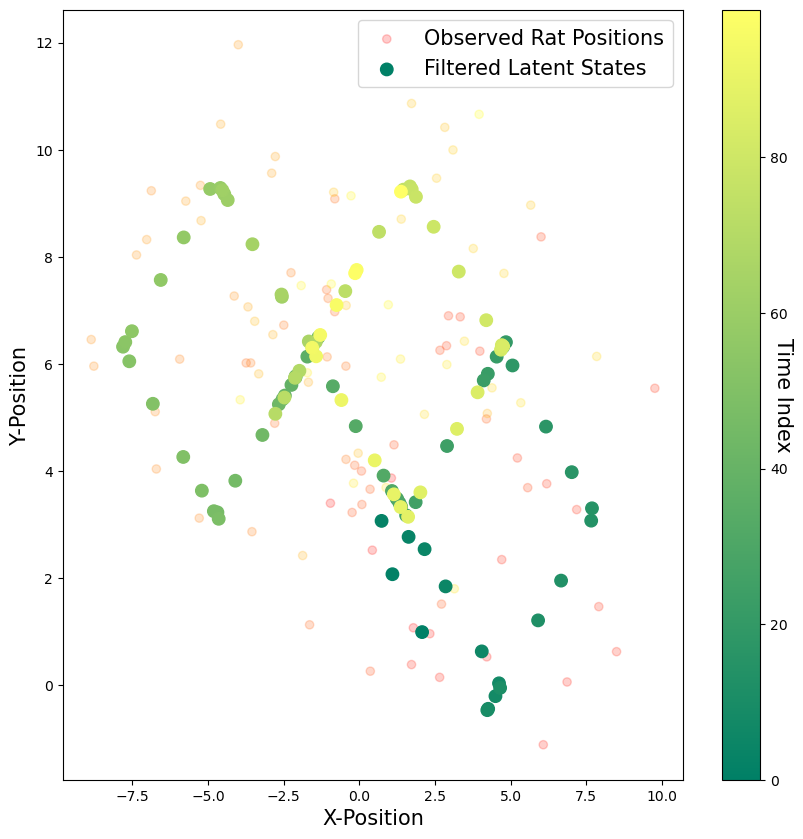

In [6]:
# Particle filter our rat position data.
np.random.seed(3)
pf_class = ParticleFiltering(dim_z=2, dim_x=2, sigma_w_zero=1.1, mu_zero=np.array([1, 1])) # TODO 
z_samples, weights = pf_class.particle_filter(observations=observation_states, n_samples=100) # TODO 

# Get the expected value of z at each timestep.
z_mean = np.sum((z_samples * weights[:,:,np.newaxis]), axis=1)

# Let's visualize our mean fit.
fig, ax = plt.subplots(1, 1, figsize=(10,10), dpi=100)
fontsize = 15
plt.scatter(observation_states[:,0], observation_states[:,1], c=t_observed, 
            cmap='autumn', label='Observed Rat Positions', alpha=0.2)

plt.scatter(z_mean[1:,0], z_mean[1:,1], c=t_observed,
            cmap='summer', label='Filtered Latent States', s=80)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Time Index', fontsize=fontsize, rotation=270)
plt.xlabel('X-Position', fontsize=fontsize)
plt.ylabel('Y-Position', fontsize=fontsize)
plt.legend(fontsize=fontsize)

plt.show()

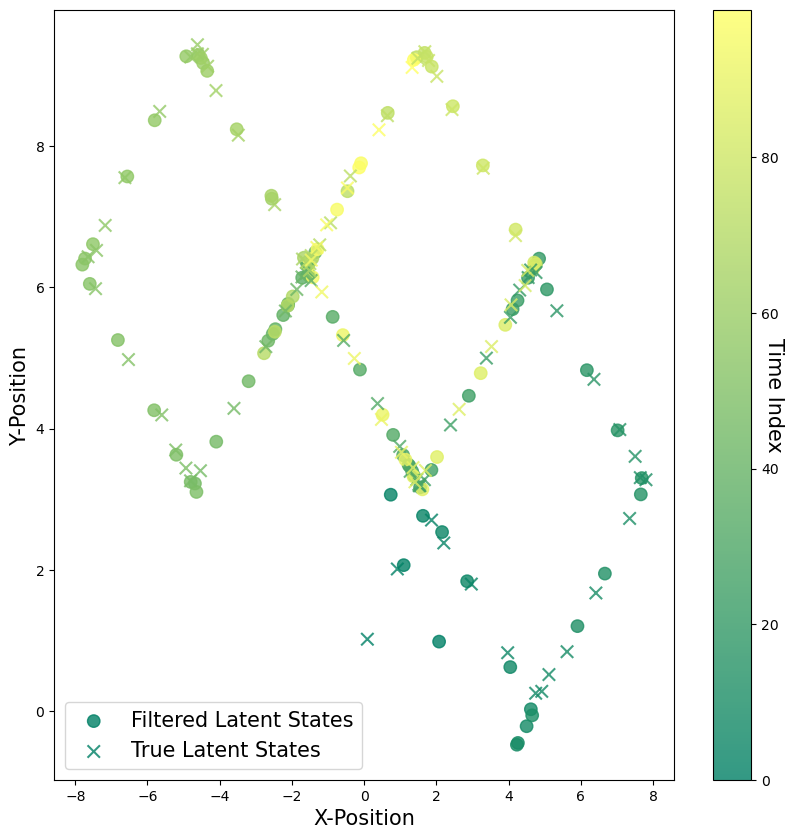

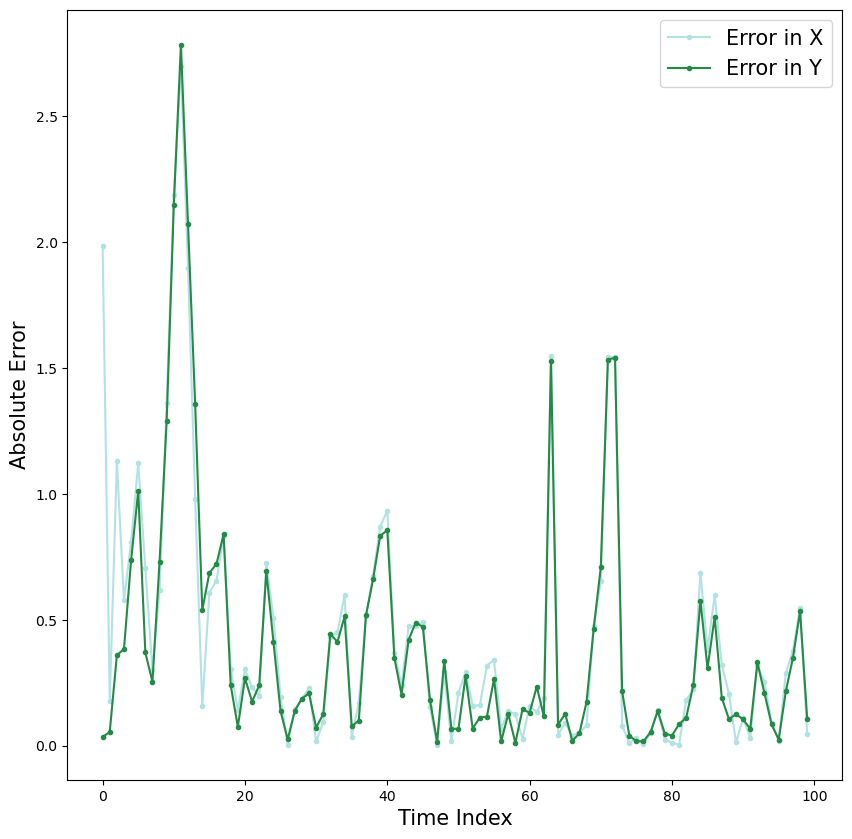

In [7]:
# Let's visualize our fit.
fig, ax = plt.subplots(1, 1, figsize=(10,10), dpi=100)
fontsize = 15
plt.scatter(z_mean[1:,0], z_mean[1:,1], c=t_observed,
            cmap='summer', label='Filtered Latent States', alpha=0.8, s=80)
plt.scatter(latent_states[1:,0], latent_states[1:,1], c=t_observed, marker='x',
            cmap='summer', label='True Latent States', alpha=0.8, s=80)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Time Index', fontsize=fontsize, rotation=270)
plt.xlabel('X-Position', fontsize=fontsize)
plt.ylabel('Y-Position', fontsize=fontsize)
plt.legend(fontsize=fontsize)

plt.show()

# Let's visualize our errors.
fig, ax = plt.subplots(1, 1, figsize=(10,10), dpi=100)
fontsize = 15

plt.plot(t_observed, np.abs(z_mean[1:,0] - latent_states[1:,0]), '.-', label='Error in X', c='#b2e2e2')
plt.plot(t_observed, np.abs(z_mean[1:,1] - latent_states[1:,1]), '.-', label='Error in Y', c='#238b45')
plt.xlabel('Time Index', fontsize=fontsize)
plt.ylabel('Absolute Error', fontsize=fontsize)
plt.legend(fontsize=fontsize)

How does the error of our later latent states compare to the error of our earlier latent states? Why might this be the case?

# Combired to the earlier latent states, our error is relatively low and steady, with only two smaller peaks at around time index 60 and 70. It is reasonable because our initial guess is not accurate. As the filter propagates through time, the effect of the initial distribution fades, allowing the model to refine its estimates based on updated observations, and thus error decreases. The peaks aroung 60 and 70 might be due to some sudden turn or move by the mice, which does not fit into our model.

## Part 3: Predicting with the Particle Filter

Run the particle filtering algorithm with sigma_w_zero = 1.1 and mu_zero = [0,0] and generate $N=200$ samples. Then predict the future observations.

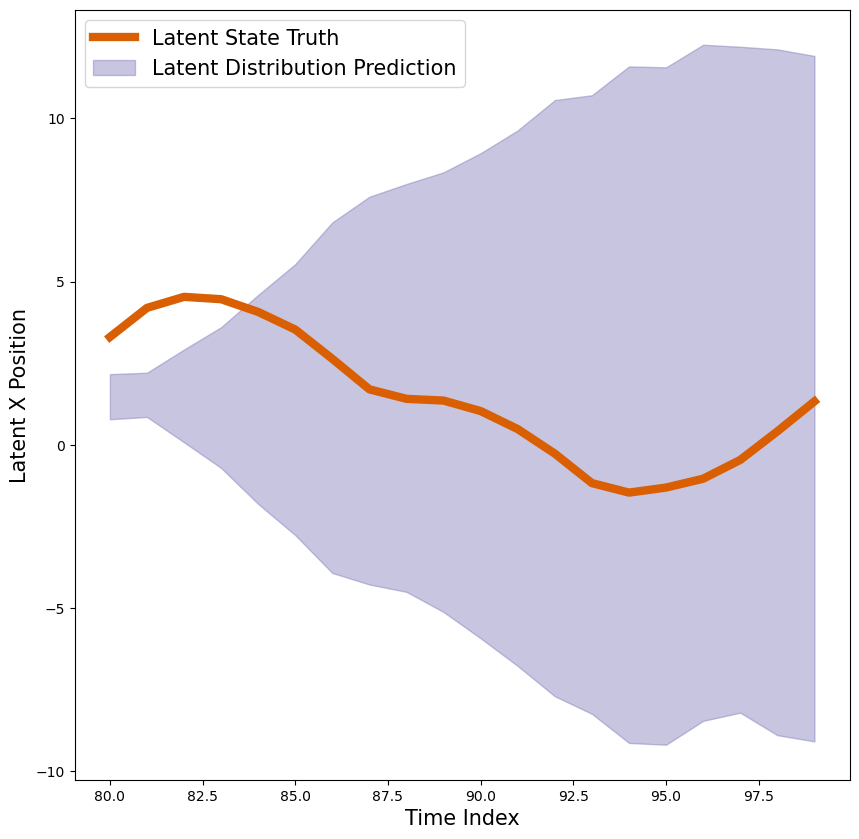

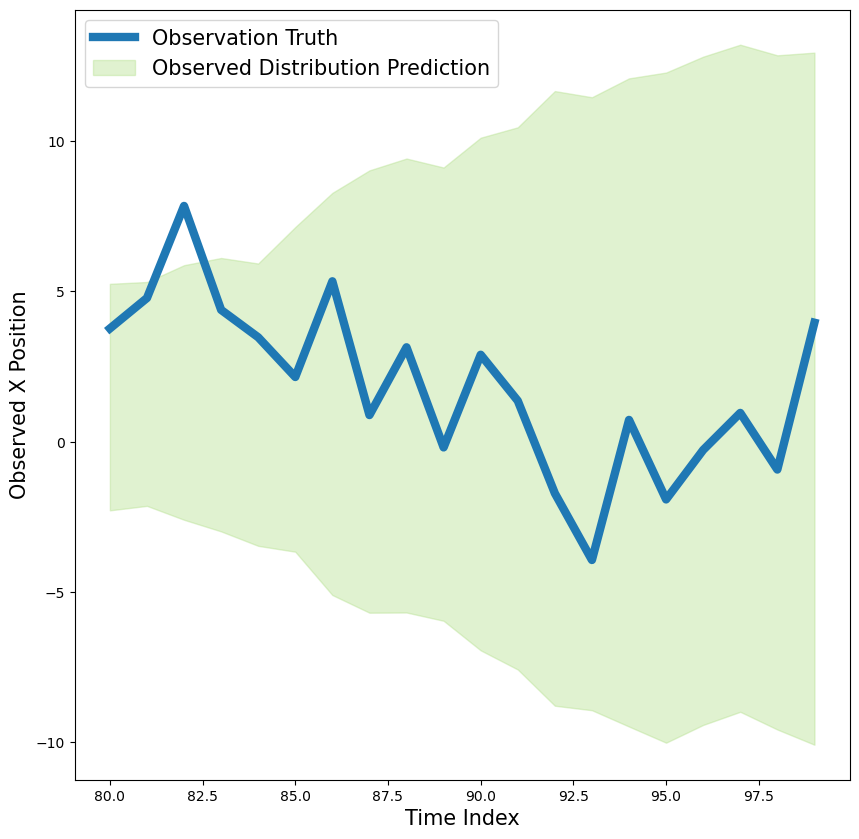

In [10]:
# Particle filter our rat position data.
np.random.seed(3)
pf_class = ParticleFiltering(dim_z=2, dim_x=2, sigma_w_zero=1.1, mu_zero=np.array([0, 0])) # TODO 
z_samples, weights = pf_class.particle_filter(observations=observation_states, n_samples=200) # TODO 
z_future, obs_future = pf_class.predict(final_latent_samples=z_samples[-1], 
                                        final_weights=weights[-1], 
                                        n_future=20)# TODO 

# Get the range of expected values of the latent state and observations
# at each timestep.
z_future_mean = np.mean((z_future), axis=1)
# We're visualizing our distribution as though it's Gaussian. 
z_future_std = np.std((z_future), axis=1)
obs_future_mean = np.mean((obs_future), axis=1)
obs_future_std = np.std((obs_future), axis=1)

# Let's visualize if the true path falls within our range.
fig, ax = plt.subplots(1, 1, figsize=(10,10), dpi=100)
fontsize = 15

plt.plot(t_observed[80:], latent_states[81:,0], label='Latent State Truth', color='#d95f02', lw=6)
plt.fill_between(t_observed[80:], z_future_mean[:,0] - 2 * z_future_std[:,0], 
                 z_future_mean[:,0] + 2 * z_future_std[:,0], 
                 label='Latent Distribution Prediction', alpha=0.4, color='#7570b3')
plt.xlabel('Time Index', fontsize=fontsize)
plt.ylabel('Latent X Position', fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10,10), dpi=100)
fontsize = 15

plt.plot(t_observed[80:], observation_states[80:,0], label='Observation Truth', color='#1f78b4', lw=6)
plt.fill_between(t_observed[80:], obs_future_mean[:,0] - 2 * obs_future_std[:,0], 
                 obs_future_mean[:,0] + 2 * obs_future_std[:,0], 
                 label='Observed Distribution Prediction', alpha=0.4, color='#b2df8a')
plt.xlabel('Time Index', fontsize=fontsize)
plt.ylabel('Observed X Position', fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()